In [1]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import numpy as np

In [3]:
direccion_servidor = 'LAPTOP-2R1SCPJG\SQLEXPRESS'
nombre_bd = 'BDVirunet'
nombre_usuario = 'sa'
password = '123456'

try:
    conexion = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + 
                              direccion_servidor+';DATABASE='+nombre_bd+';UID='+nombre_usuario+';PWD=' + password)
    
    print("conexión exitosa")
    
except Exception as e:
    print("Ocurrió un error al conectar a SQL Server: ", e)

conexión exitosa


In [4]:
dFechaInicio = '2019-01-01'
dFechaFin = '2019-12-31'

In [6]:
try:
    with conexion.cursor() as cursor:
            consulta = "exec STP_OBTENER_TOTALIZADO_PLAGAS ?,?,?,?"
            cursor.execute(consulta, (dFechaInicio, dFechaFin, 1,0))

            rows = cursor.fetchall()
            
            #df = pd.DataFrame((tuple(t) for t in rows)) 
            
            cols = []
            
            for i,_ in enumerate(cursor.description):
                cols.append(cursor.description[i][0])

            pd.DataFrame(np.array(rows), columns = cols)
            
            #cursor.close()
            
            df = pd.DataFrame(columns =['Evaluador','Fecha','Fundo','Filtrado','Turno','Lote','Grupo_Plaga','Plaga','Caracteristica','Suma','Grado','Promedio','Porcentaje'] )
            for i in range(len(rows)):
                df.loc[i] = list(rows[i])
except Exception as e: 
    print(e)

## Clima

In [7]:
data_weather = pd.ExcelFile('D:/bibliografia de tesis/Datos/Datos Climaticos Viru Palto.xlsx')
df_weather = data_weather.parse('TABLA')  
data_weather.close()

In [8]:
df_weather = df_weather[df_weather['Año'] == 2019]

In [9]:
df_weather.reset_index(drop = True, inplace = True)

In [10]:
df_weather = df_weather[['Fecha','ET(mm).','Tº MIN/DIA (°C)','Tº MAX/DIA (°C)','Rad. Solar Prom.','HUMEDAD PROM.', 'T° Prom/Día (°C)']]
df_weather = df_weather.rename(columns = {'ET(mm).' : 'ET', 
                                      'Tº MIN/DIA (°C)' : 'T_MIN',
                                     'Tº MAX/DIA (°C)': 'T_MAX',
                                     'Rad. Solar Prom.' : 'RS_PROM',
                                     'HUMEDAD PROM.': 'HM_PROM',
                                      'T° Prom/Día (°C)': 'TMP_PROM'})

In [11]:
arrFiltrados = df['Filtrado'].unique()

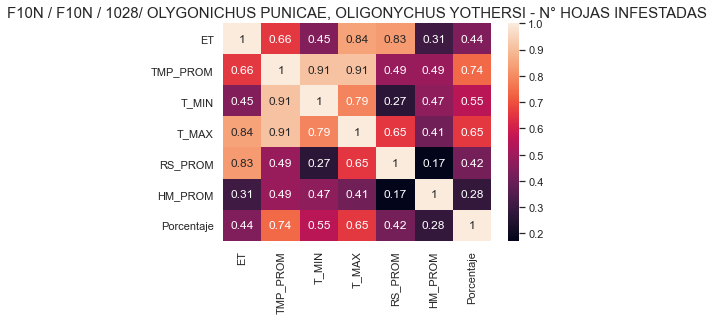

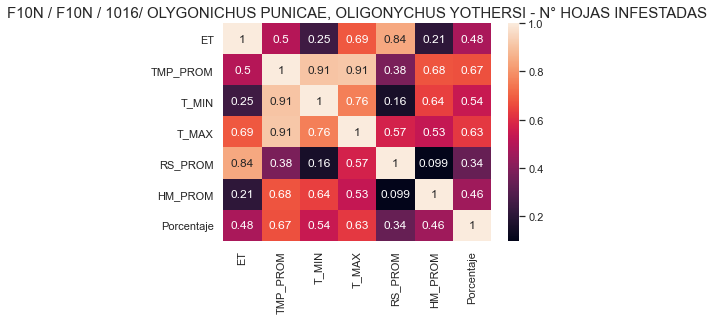

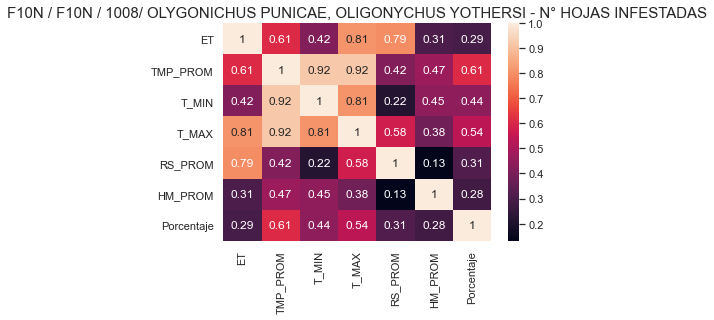

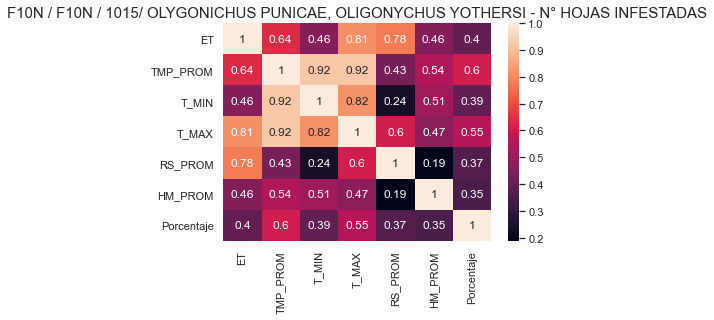

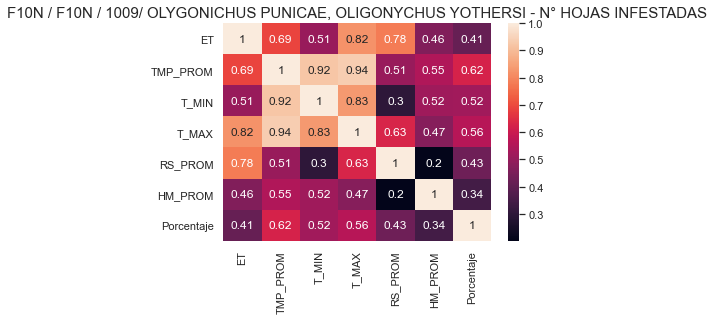

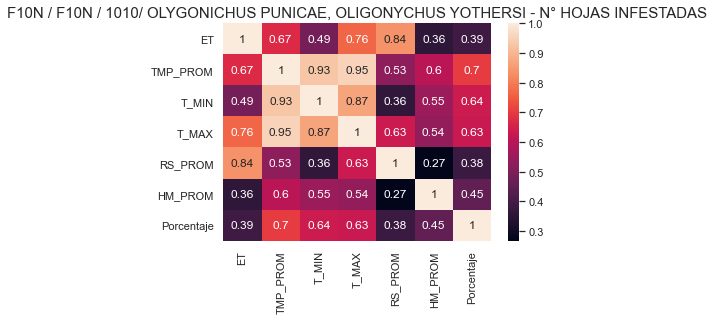

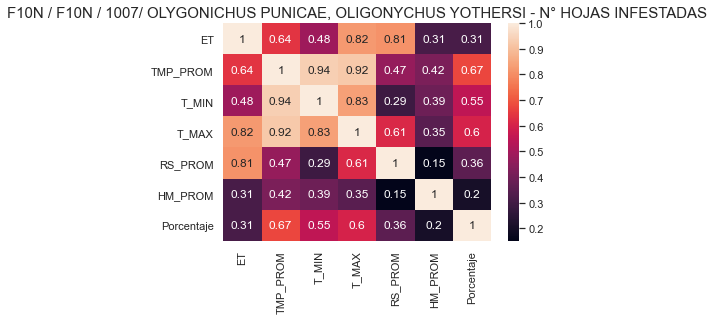

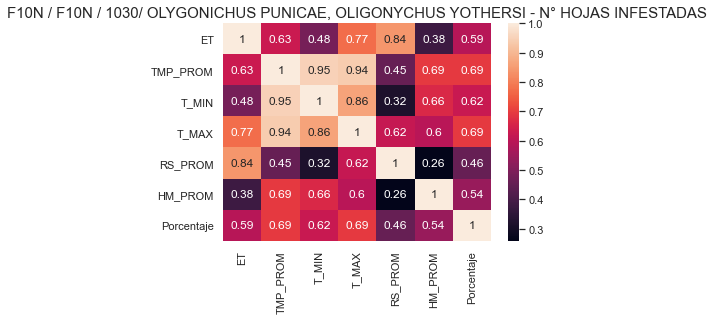

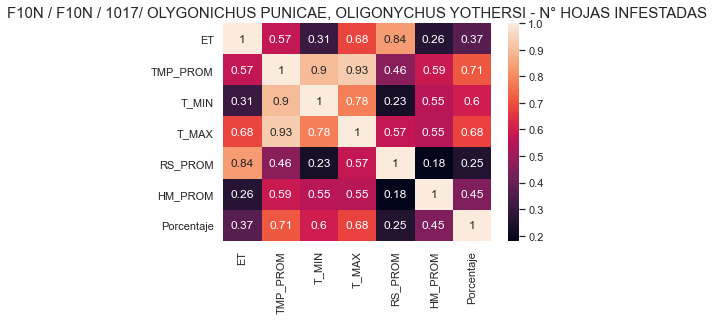

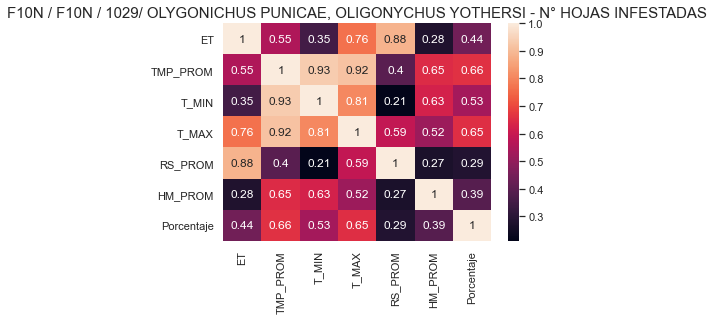

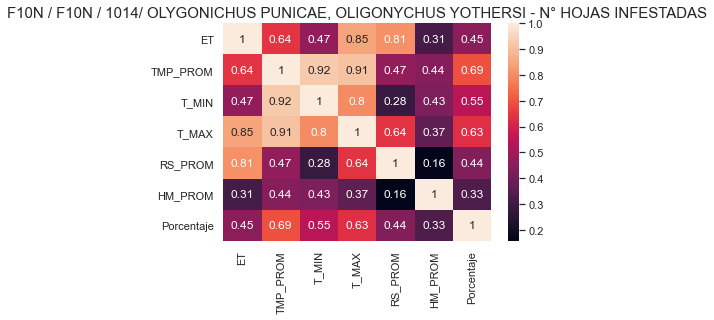

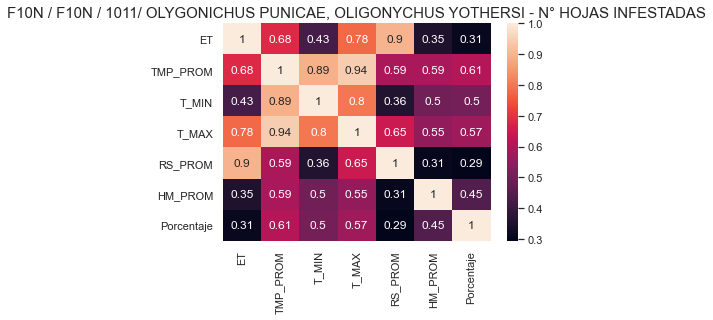

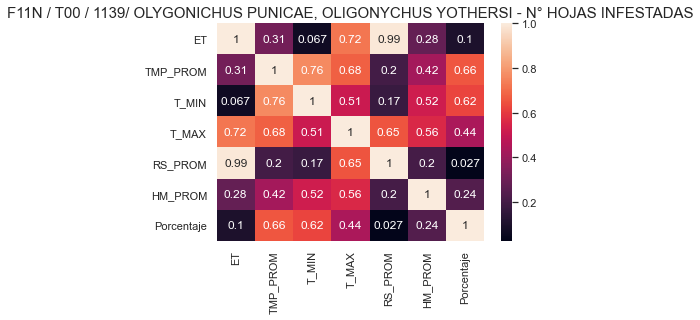

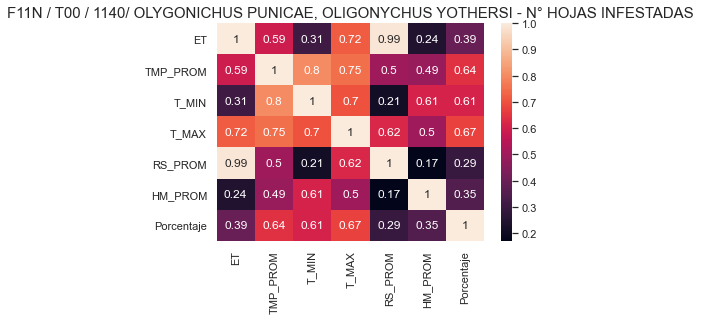

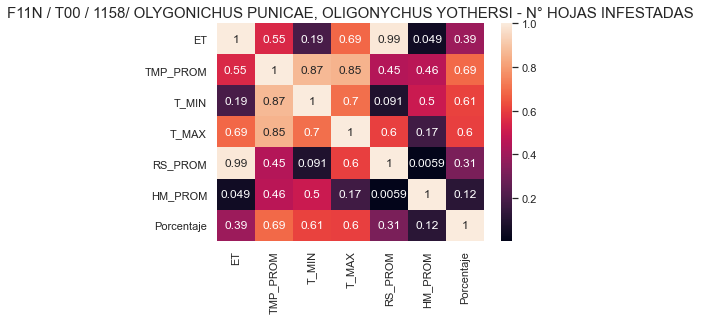

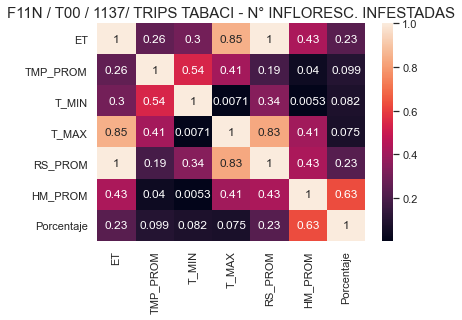

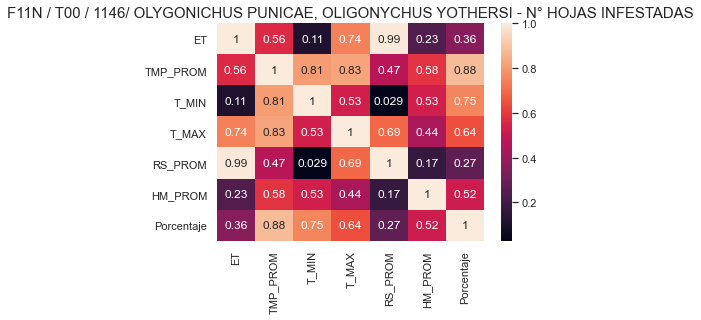

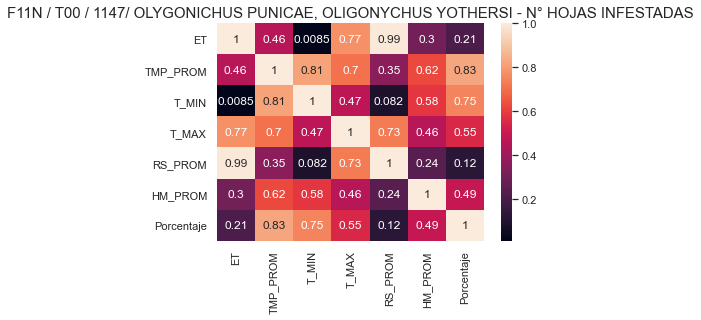

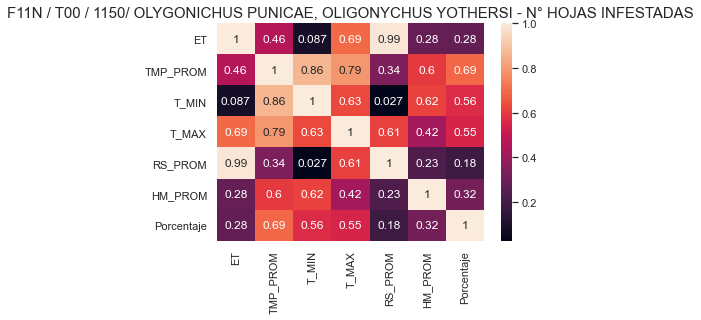

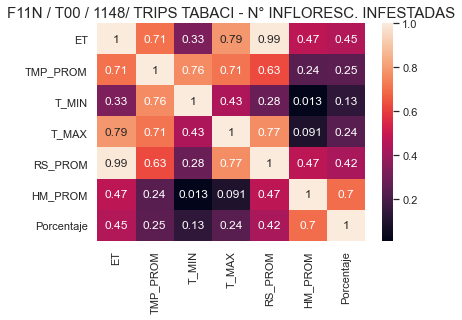

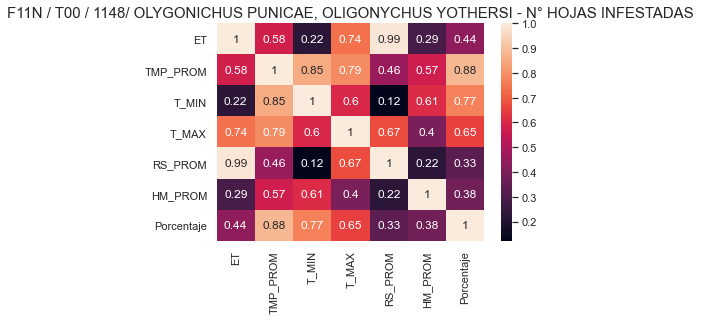

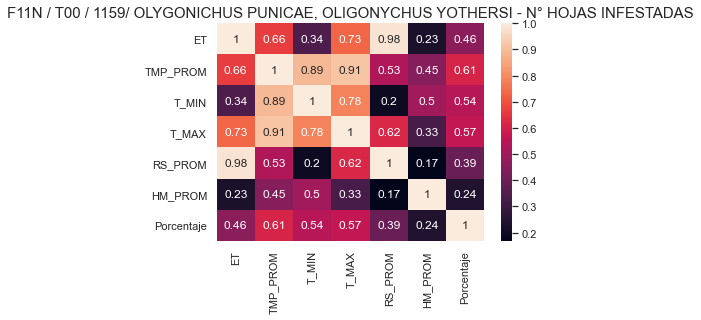

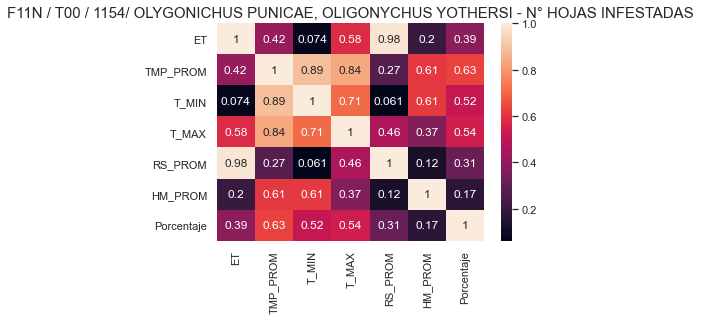

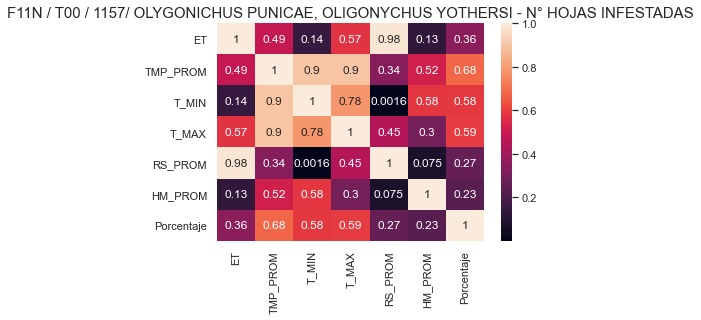

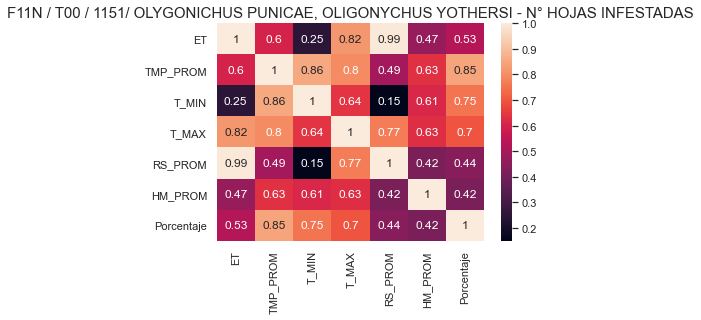

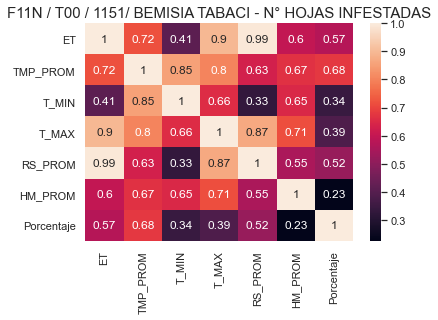

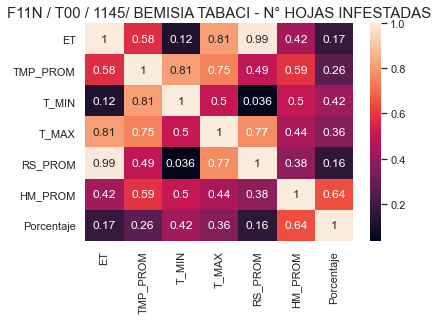

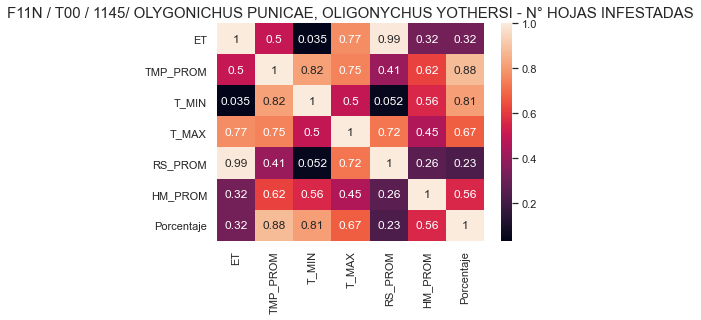

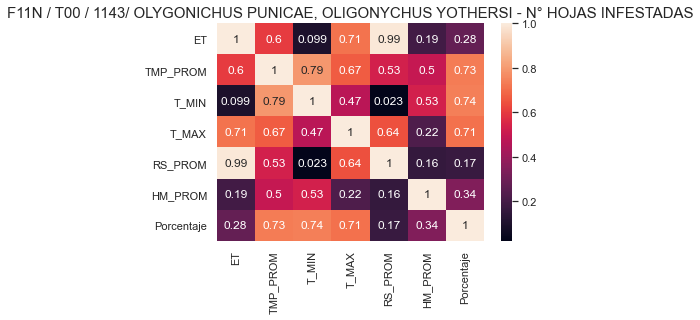

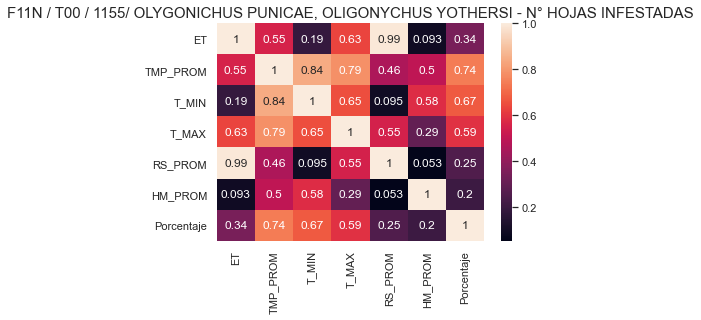

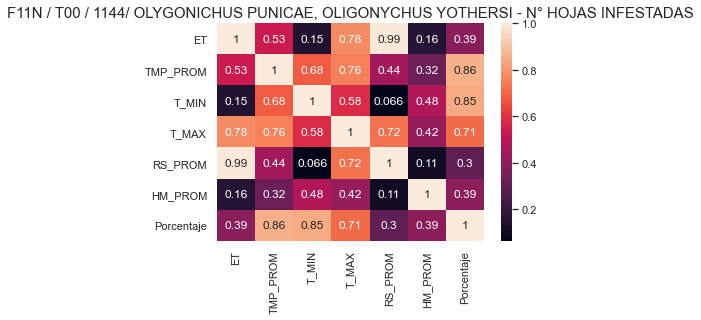

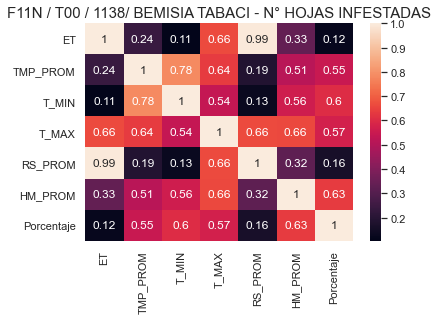

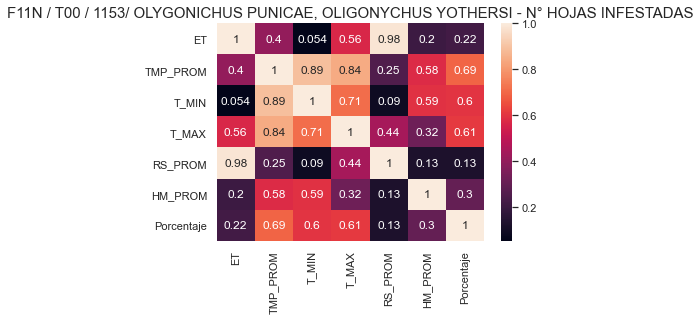

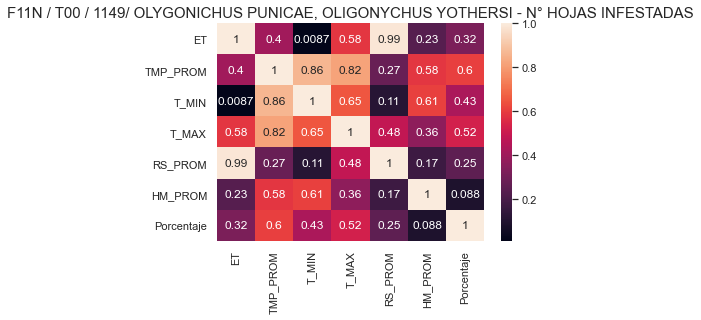

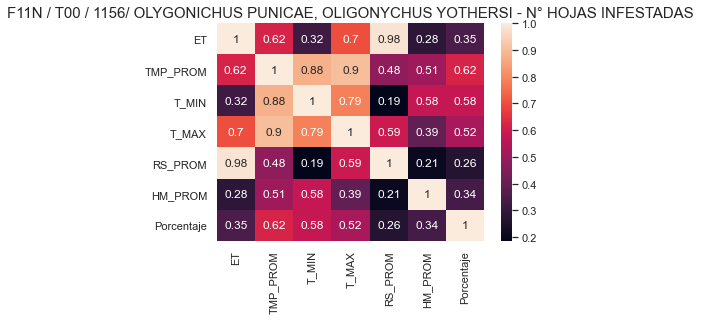

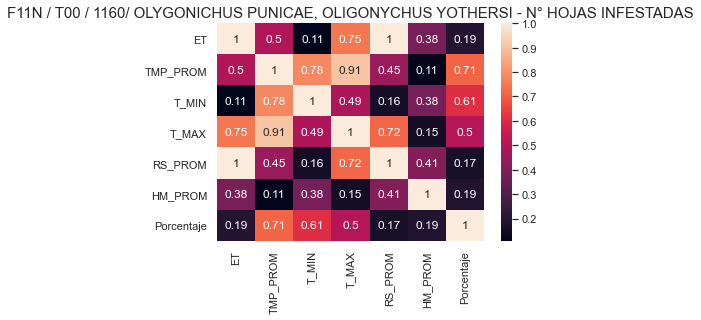

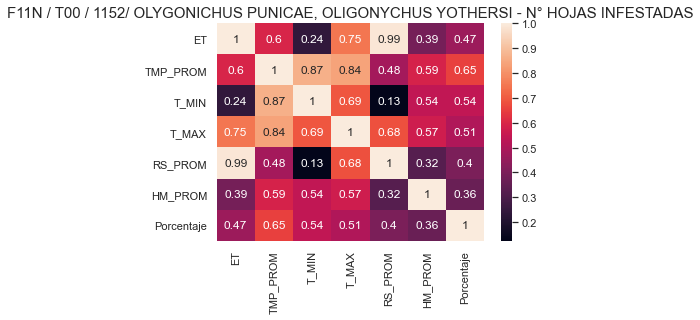

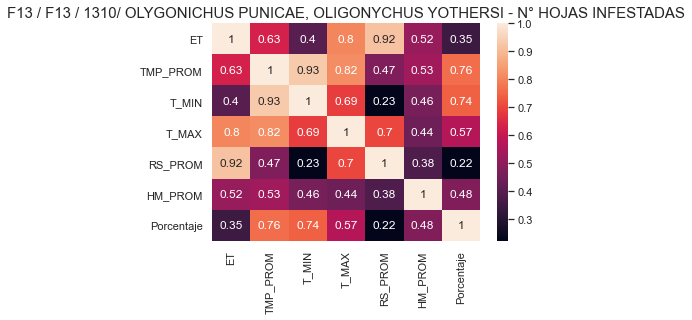

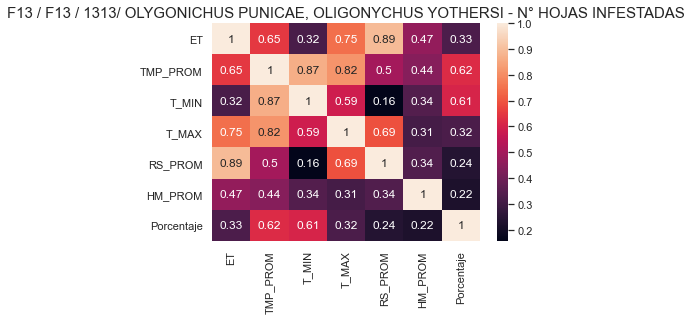

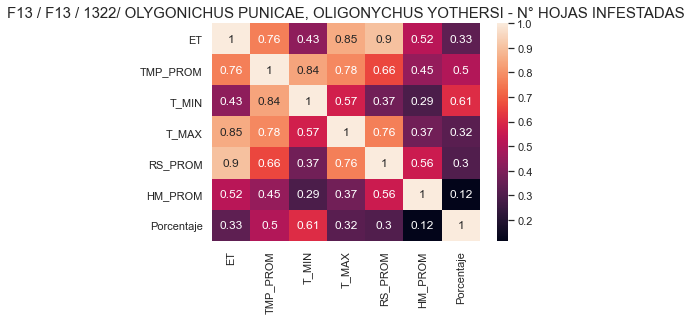

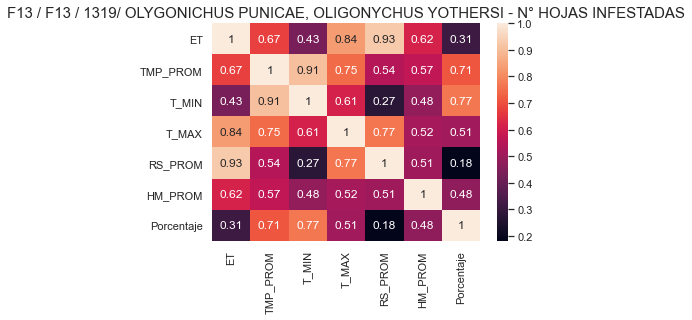

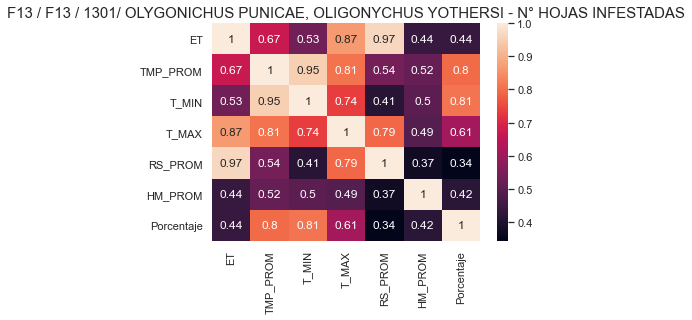

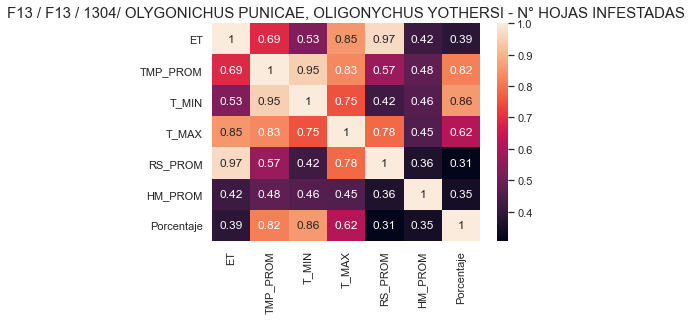

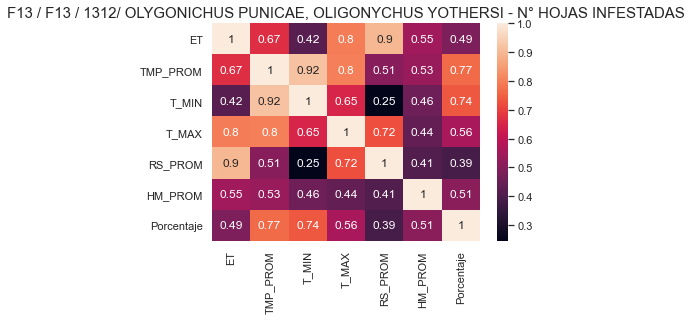

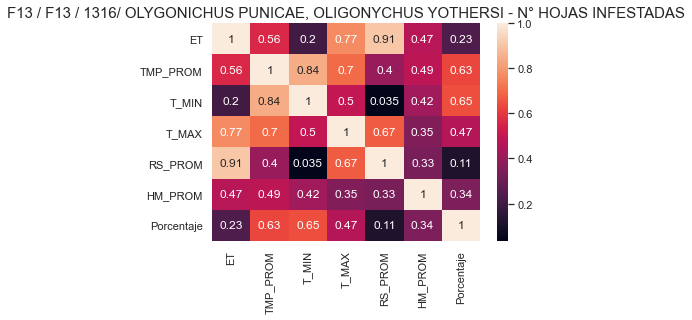

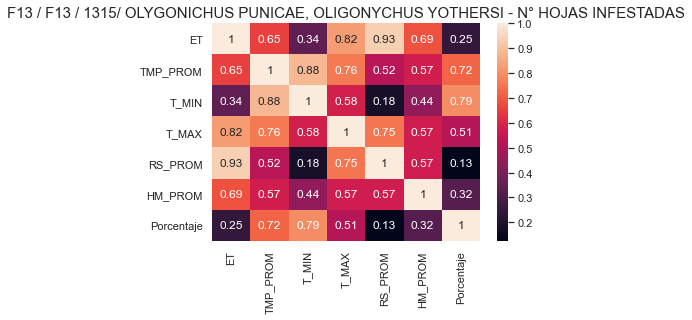

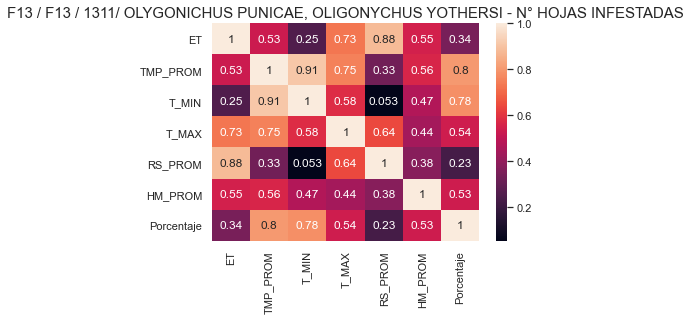

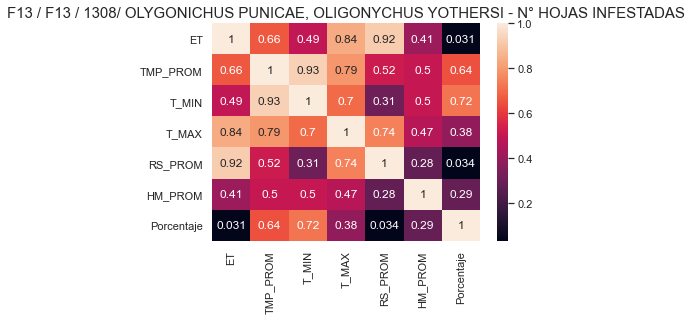

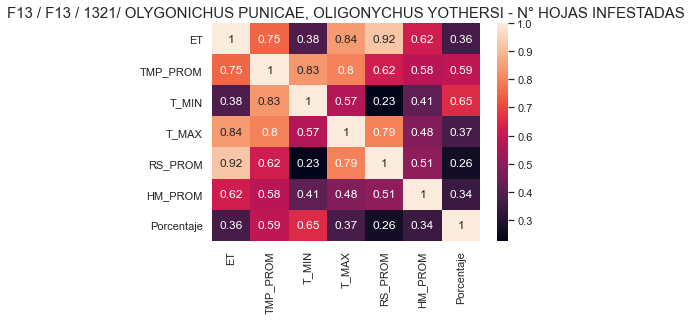

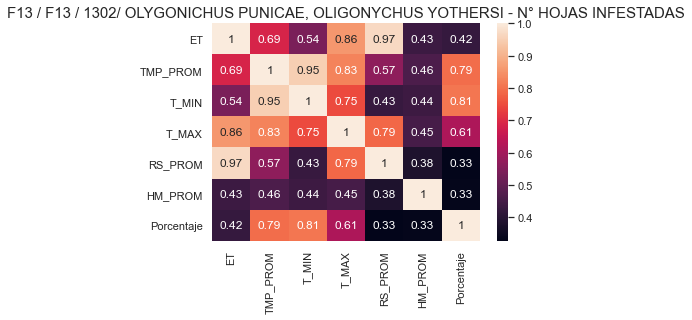

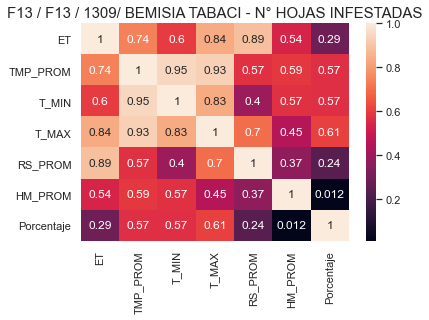

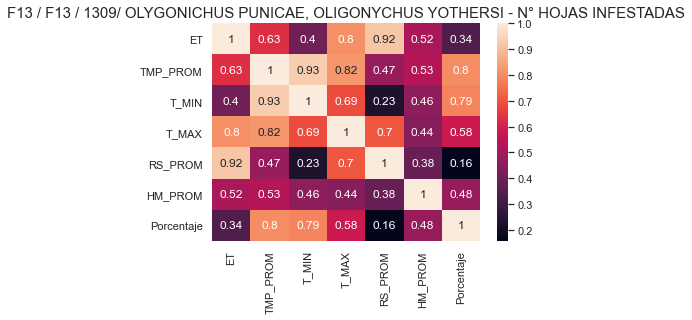

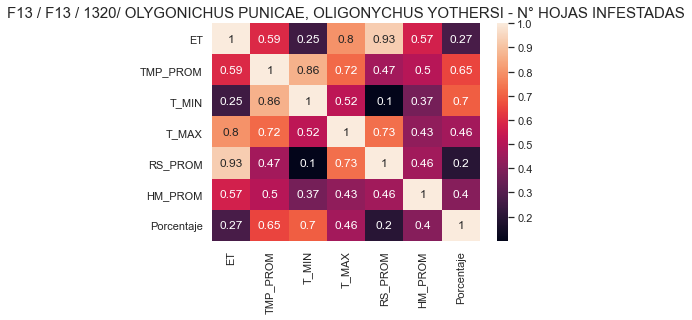

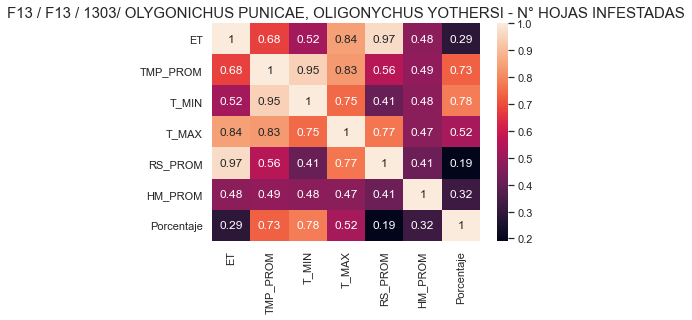

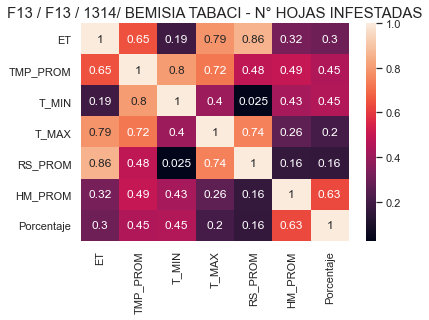

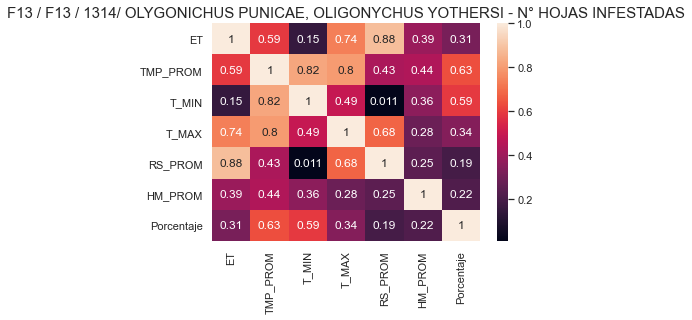

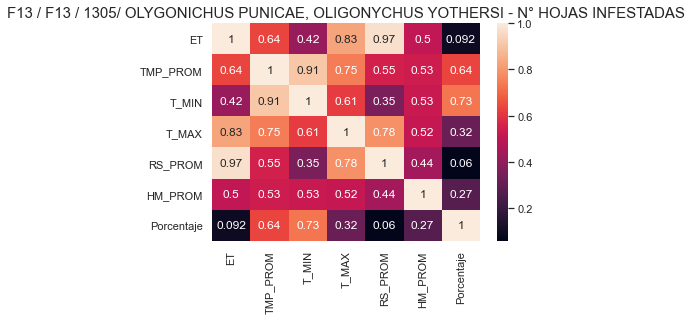

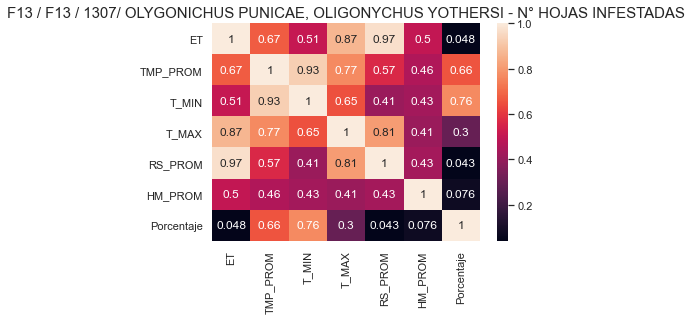

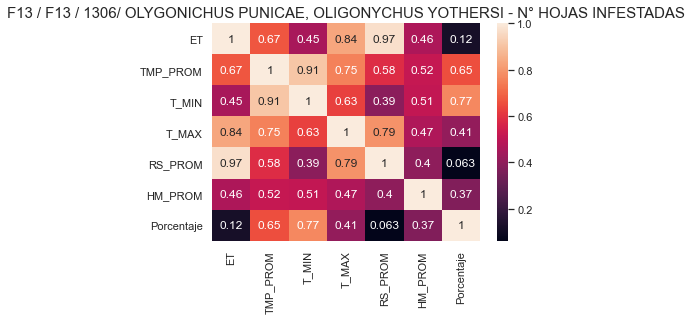

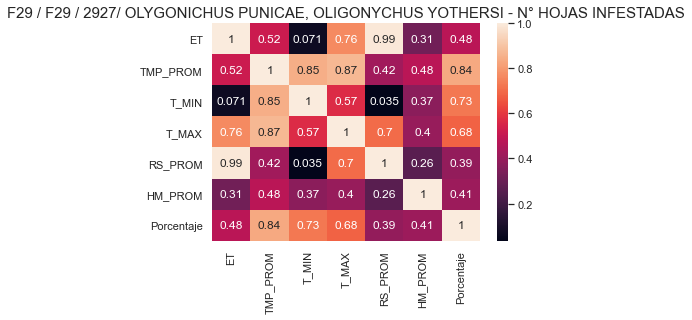

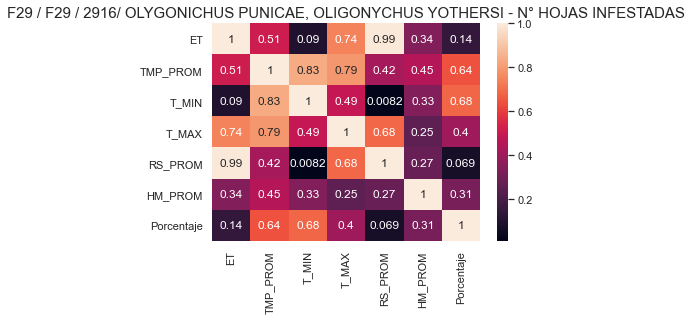

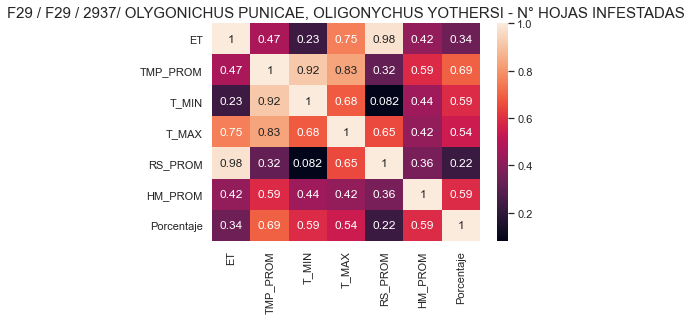

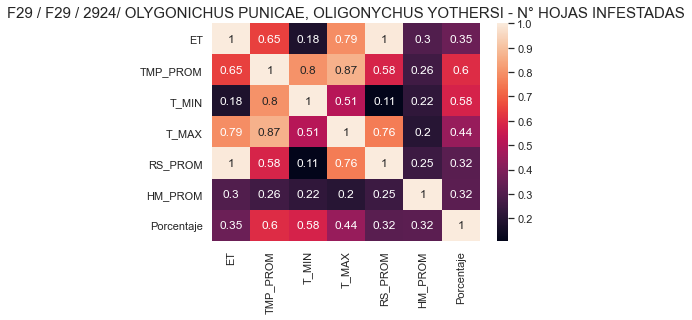

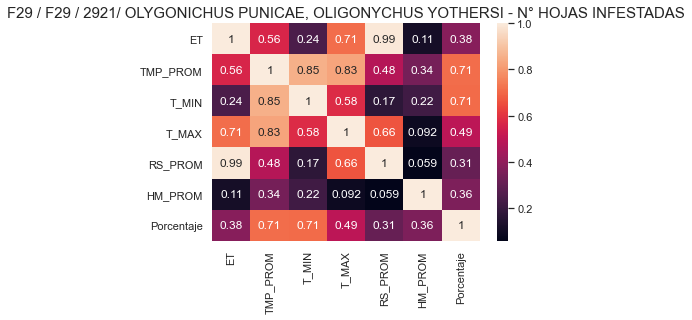

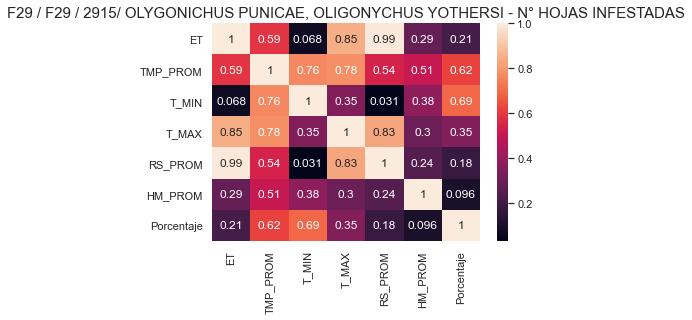

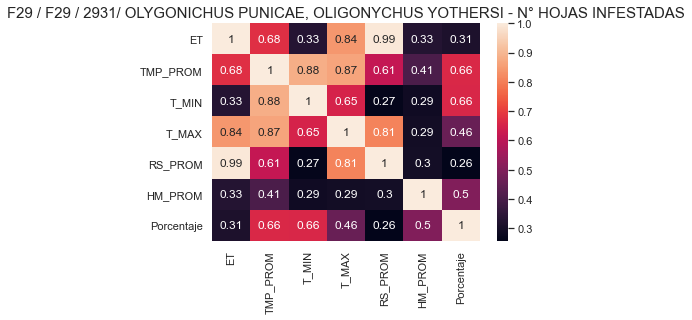

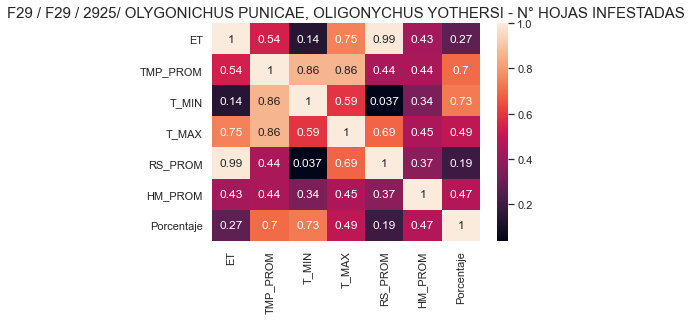

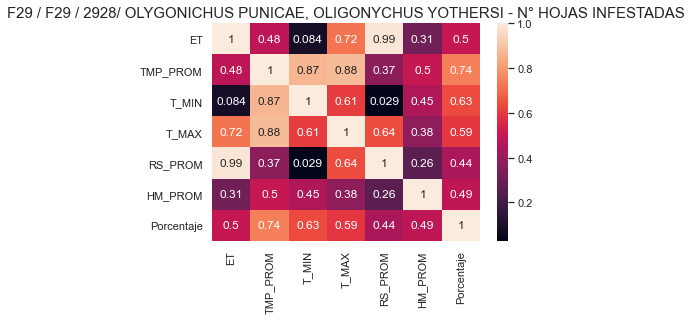

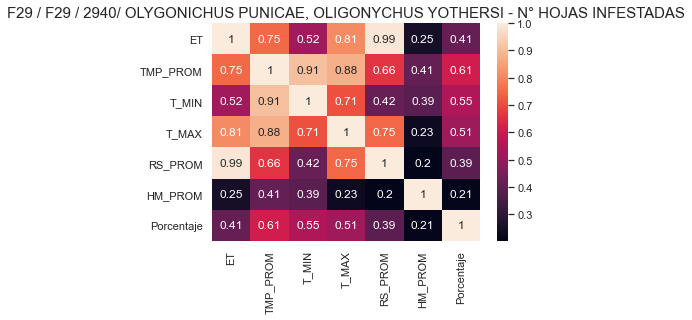

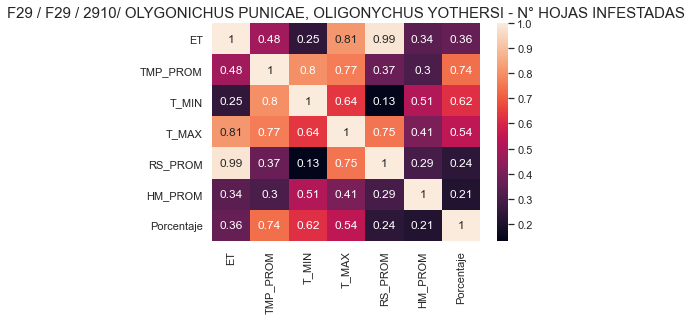

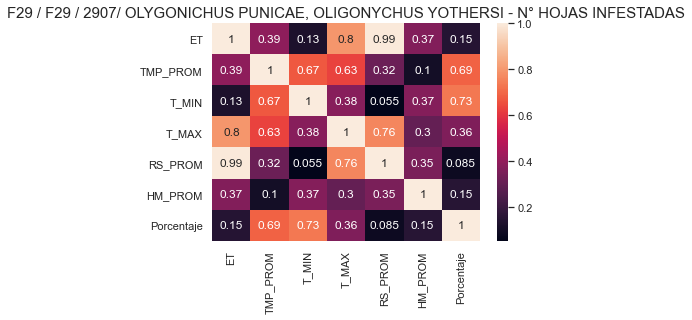

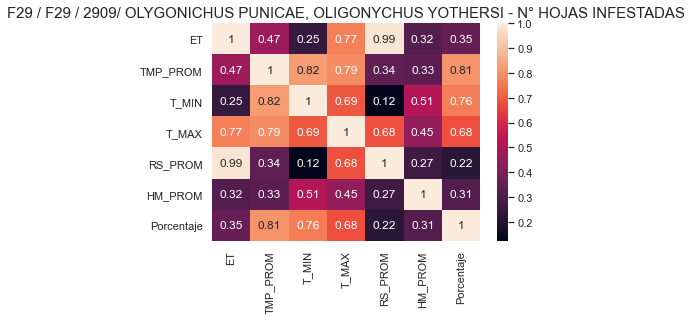

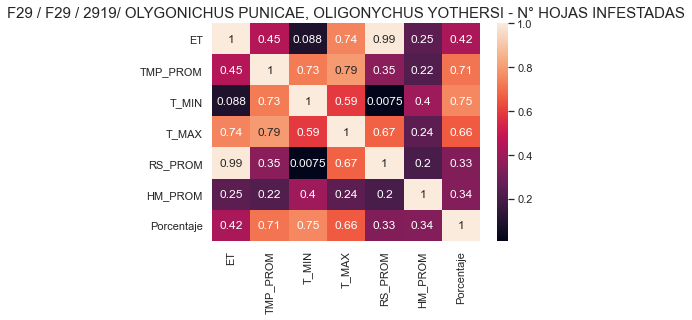

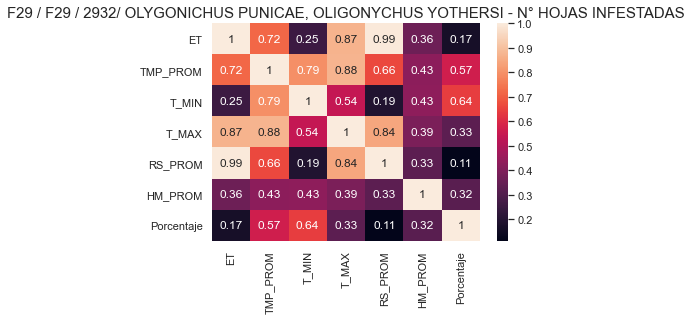

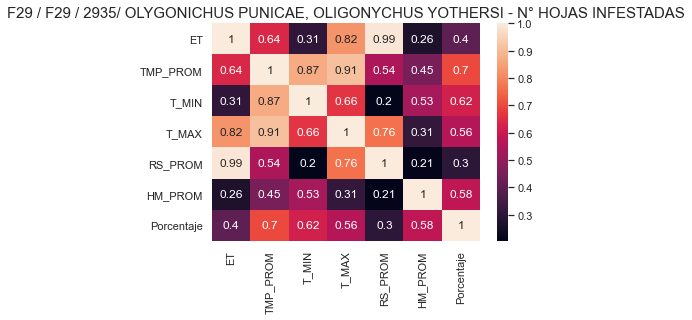

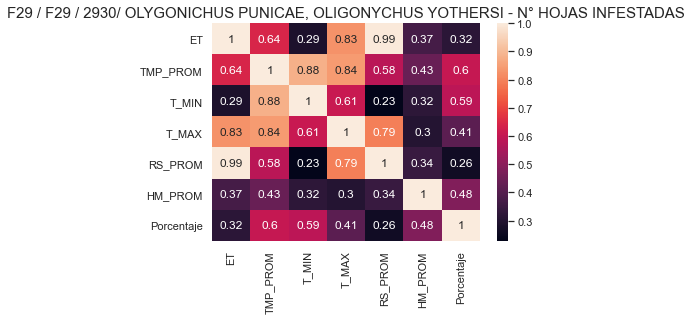

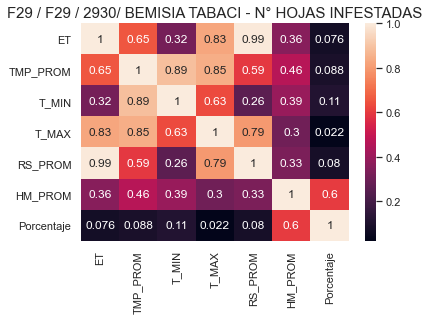

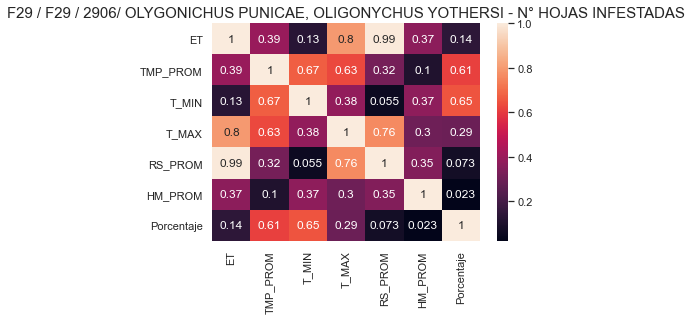

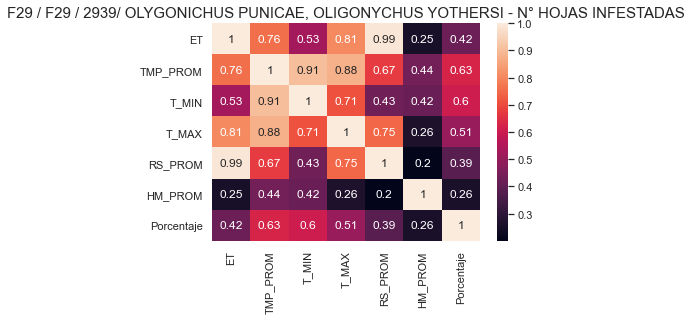

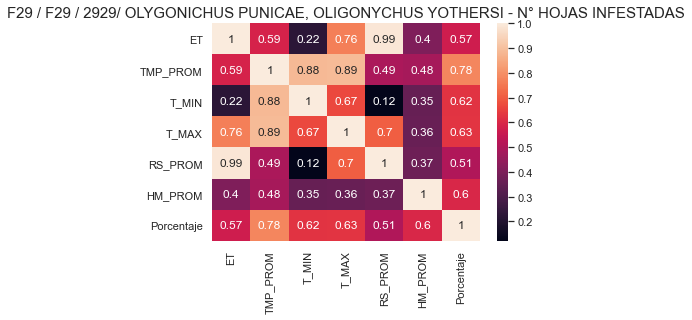

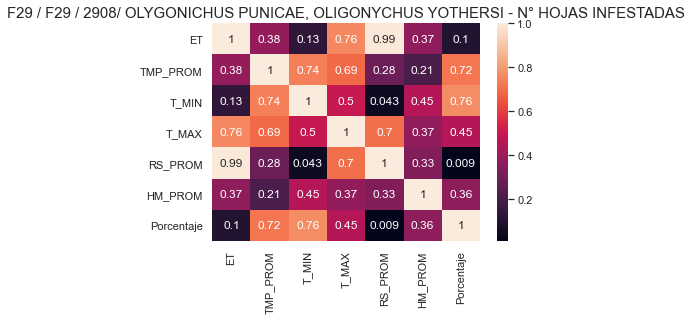

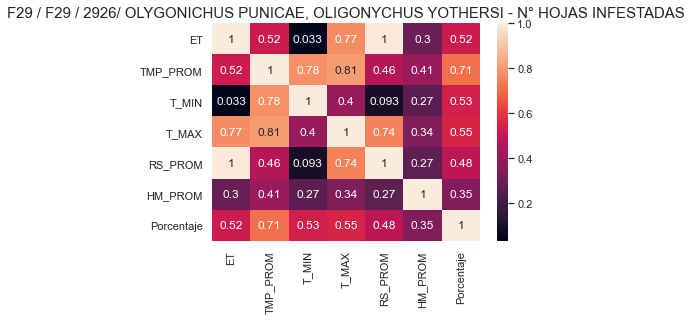

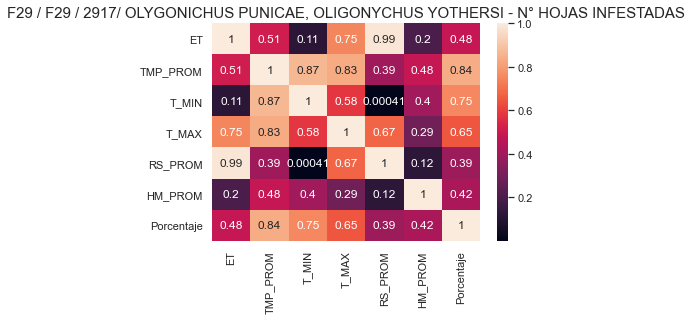

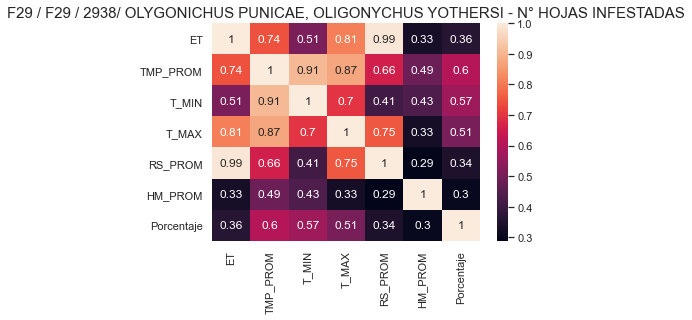

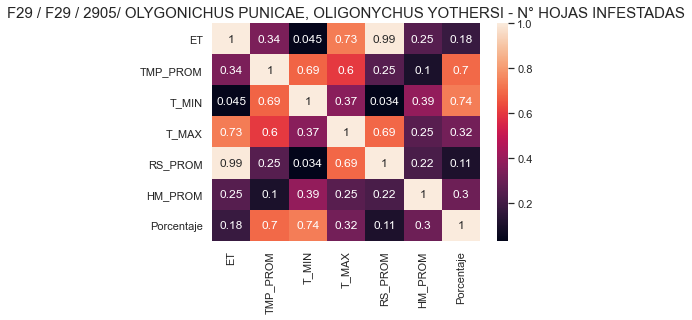

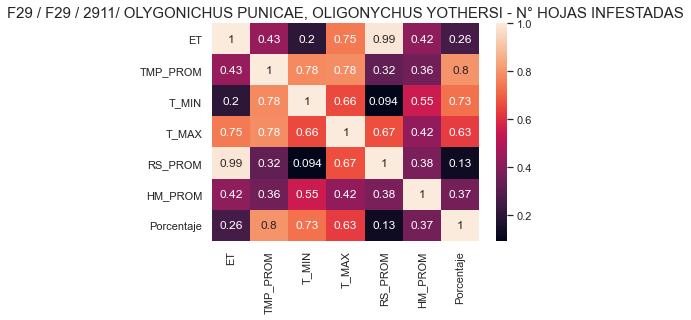

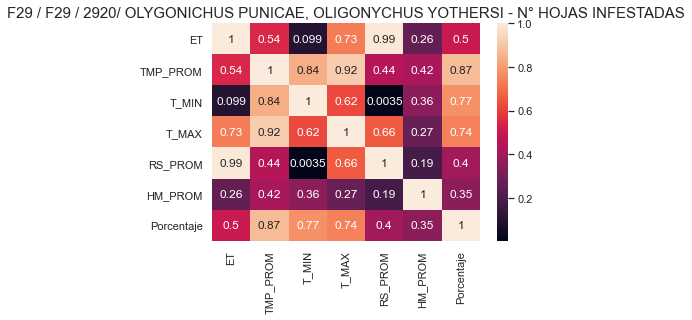

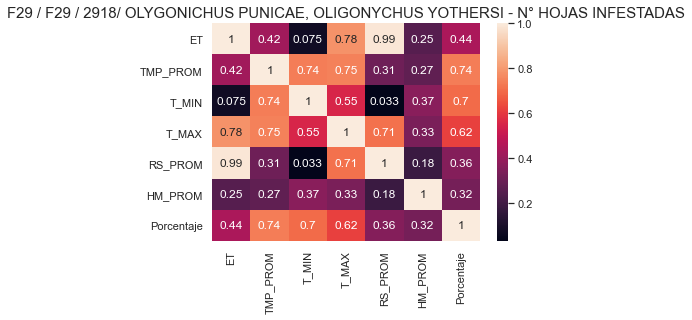

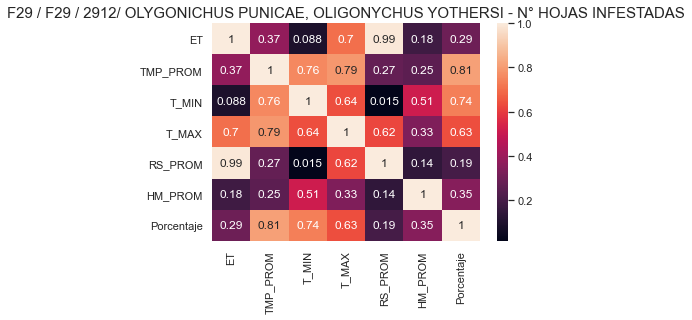

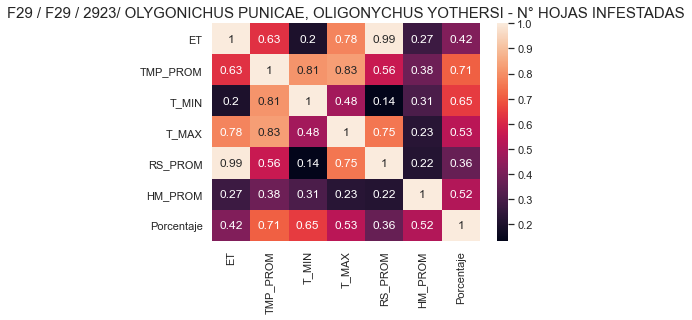

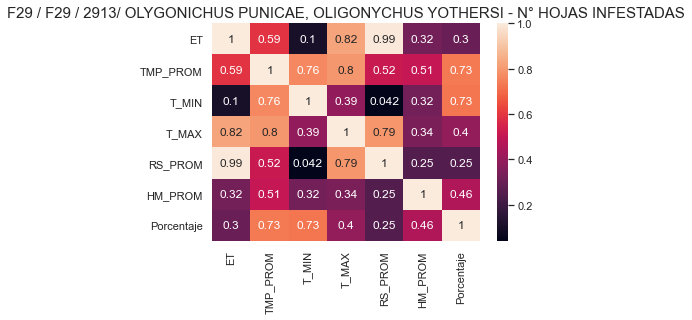

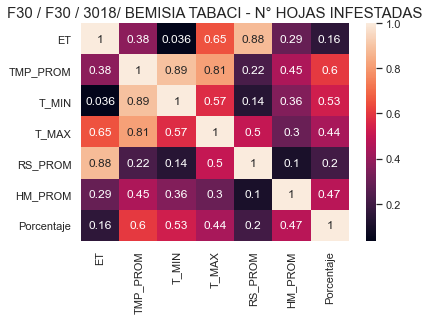

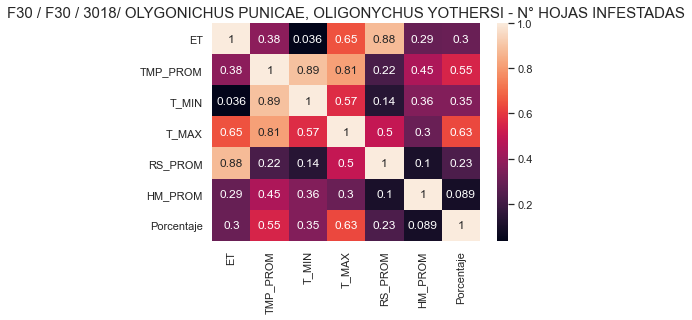

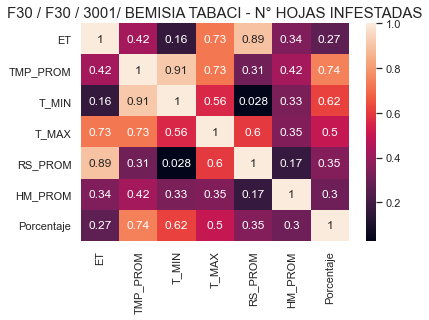

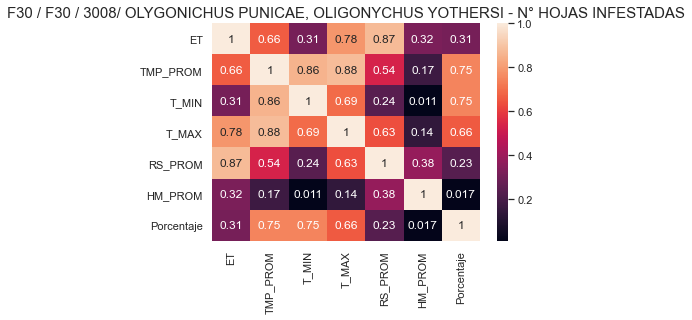

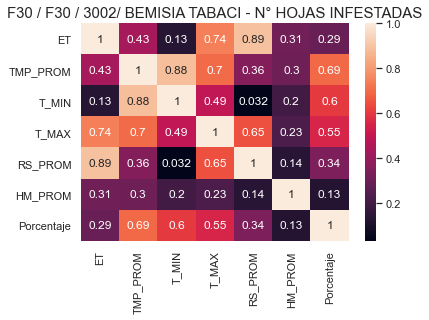

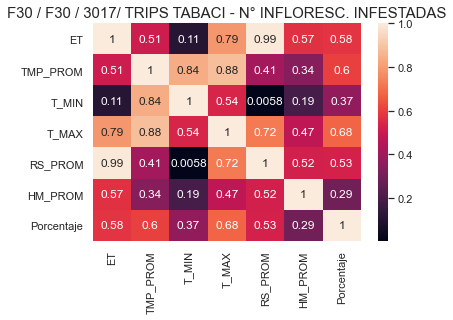

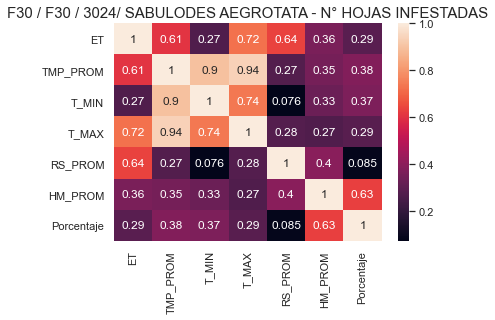

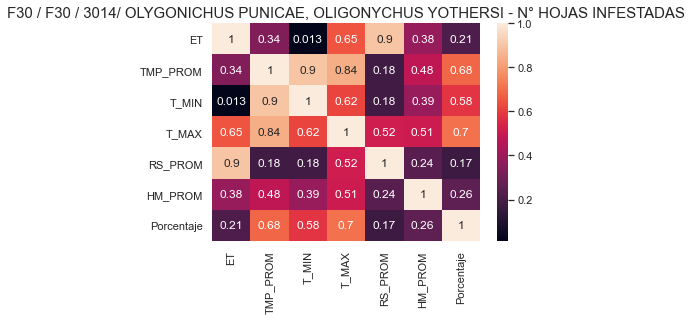

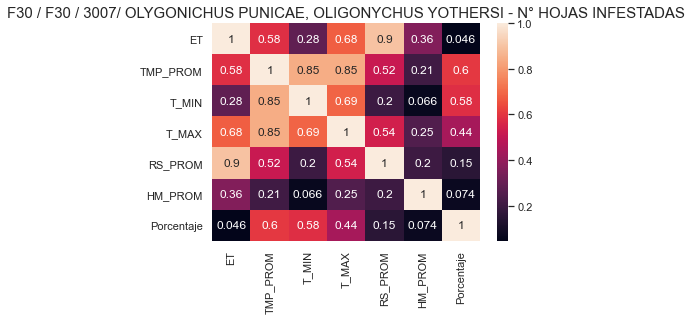

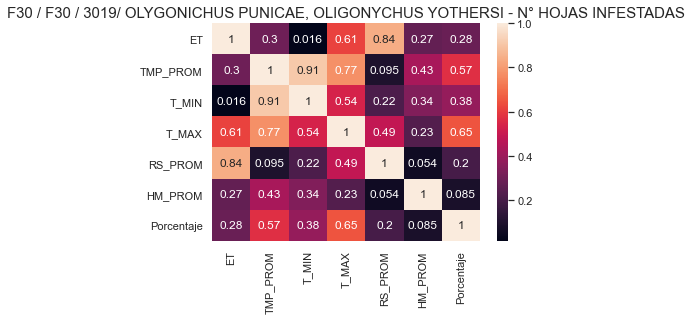

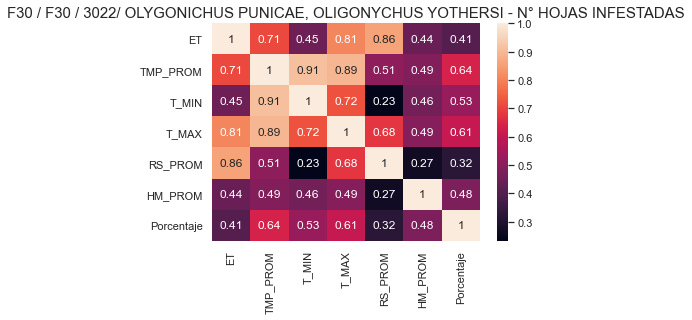

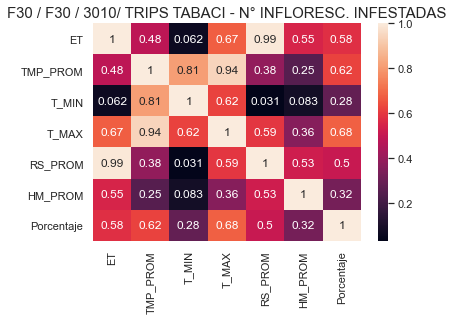

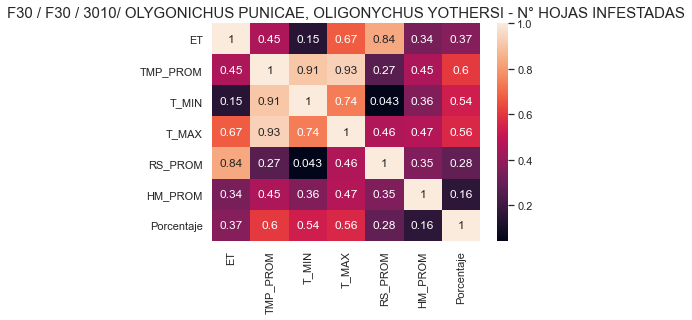

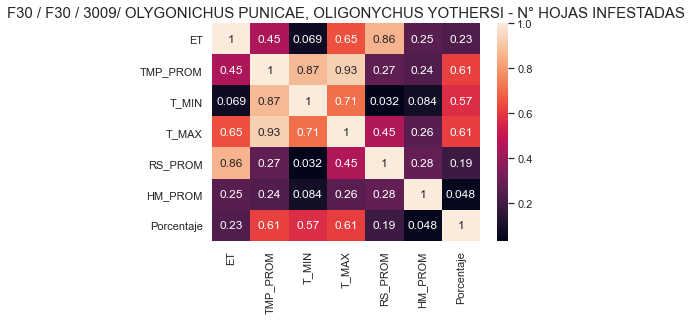

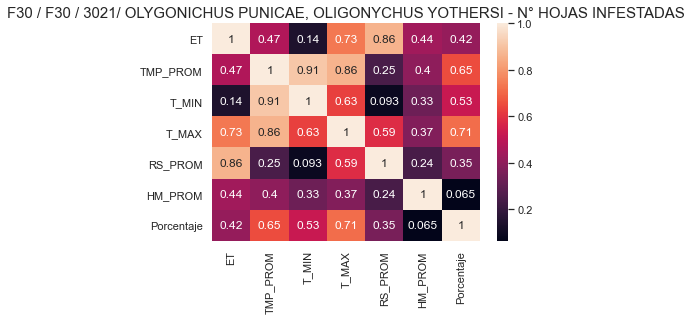

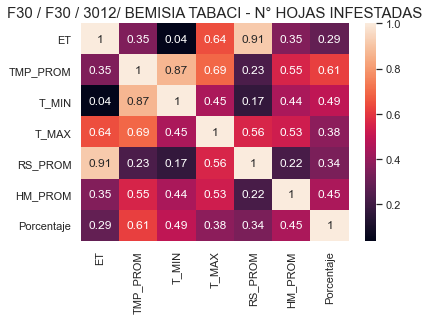

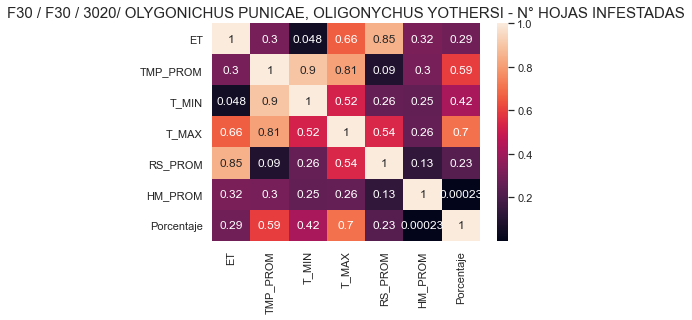

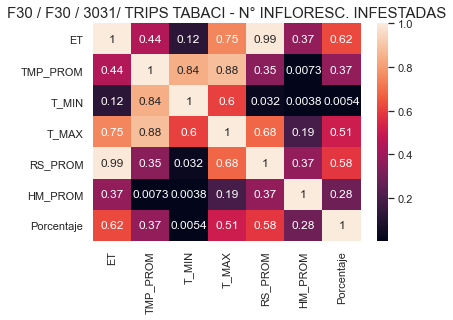

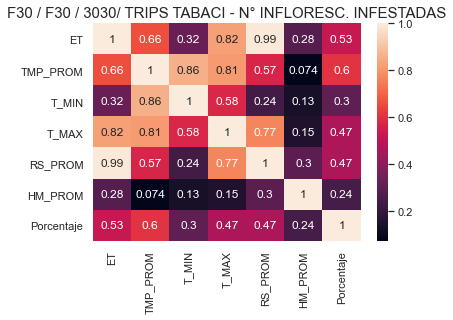

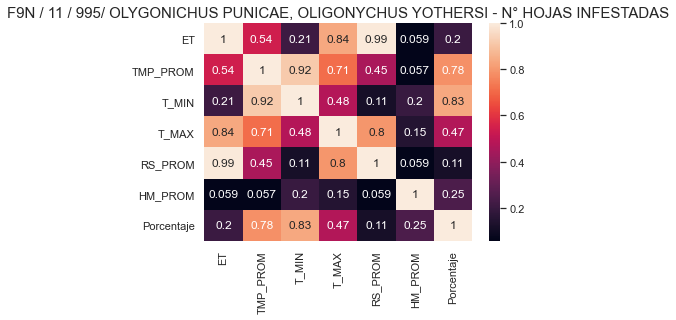

In [12]:
arrPlagas = []
dfFilter = df
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Porcentaje'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    df_union = df_union[['Fecha','ET','TMP_PROM','T_MIN','T_MAX','RS_PROM','HM_PROM','Porcentaje']]        
                                   
                    df_union[["Porcentaje"]] = df_union[["Porcentaje"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Porcentaje'] > 0.60]

                    if dfCorrelacion_index.shape[0] > 1:   
                        
                        dfCorrexLote = dfCorrexLote.append({'Filtrado': filtrado,'Turno': turno,'Lote' : lote, 'Plaga': plaga,'Caracteristica': caracteristica},ignore_index=True)
                        arrPlagas.append(plaga)
                        #Creando Mapa de Calor
                        sns.set()
                        ax = sns.heatmap(dfCorrelacion, annot = True)
                        iContador = iContador + 1
                        plt.title('F{} / {} / {}/ {} - {}'.format(filtrado,turno, lote,plaga,caracteristica), fontdict = { 'fontsize' : '15'})
                        plt.show()

In [13]:
arrPlagas = np.array(arrPlagas)
np.unique(arrPlagas)

array(['BEMISIA TABACI', 'OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI',
       'SABULODES AEGROTATA', 'TRIPS TABACI'], dtype='<U41')

# Entrenamiento de datos

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import joblib

In [15]:
dfFilter = df
dfFilter.head()

Evaluador       Fecha         Fundo Filtrado Turno  Lote Grupo_Plaga  \
0  tvelasquez  2019-08-29  VIRU - PALTO      10N  F10N  1028        None   
1   lminchola  2019-06-20  VIRU - PALTO      10N  F10N  1016       HOJAS   
2     acampos  2019-05-27  VIRU - PALTO      10N  F10N  1008       HOJAS   
3     acampos  2019-07-03  VIRU - PALTO      10N  F10N  1012        None   
4   jescobedo  2019-09-12  VIRU - PALTO      10N  F10N  1015        None   

                                       Plaga       Caracteristica Suma Grado  \
0                    CONTROLADORES NATURALES          NEUROPTEROS    5    --   
1                             BEMISIA TABACI  N° HOJAS INFESTADAS   13    --   
2  OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI  N° HOJAS INFESTADAS   77    --   
3                    CONTROLADORES NATURALES          NEUROPTEROS    8    --   
4                    CONTROLADORES NATURALES          NEUROPTEROS    4    --   

  Promedio Porcentaje  
0       --         20  
1       --         13  
2       --         77  
3       --         32  
4       --         16

------------------------------------------------------------
F10N - F10N - 1028 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 34
Coeficiente: [6.27656248 0.13878137] 
------------------------------------------------------------------


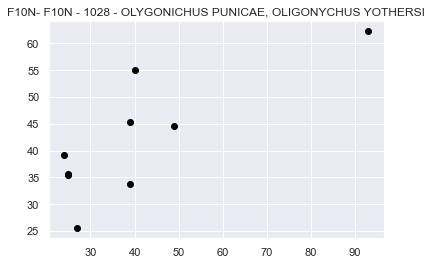

------------------------------------------------------------
F10N - F10N - 1016 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 32
Coeficiente: [ 5.13823314 -0.48293174] 
------------------------------------------------------------------


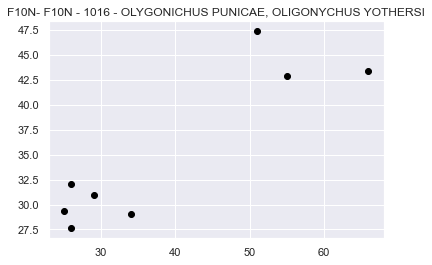

------------------------------------------------------------
F10N - F10N - 1008 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 34
Coeficiente: [4.74152986] 
------------------------------------------------------------------


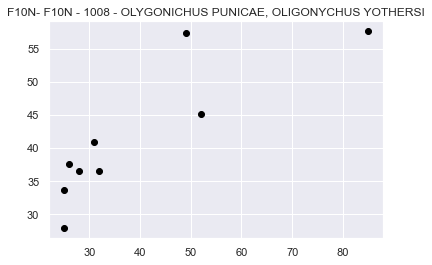

------------------------------------------------------------
F10N - F10N - 1015 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 34
Coeficiente: [3.98588431] 
------------------------------------------------------------------


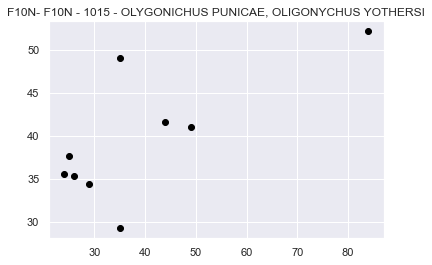

------------------------------------------------------------
F10N - F10N - 1009 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 34
Coeficiente: [4.51669892] 
------------------------------------------------------------------


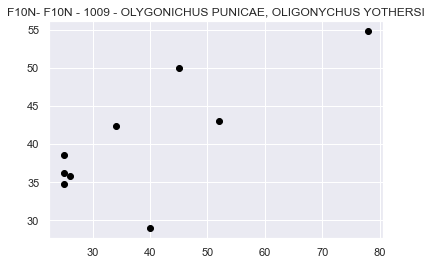

------------------------------------------------------------
F10N - F10N - 1010 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 32
Coeficiente: [ 8.38928189 -2.21707684 -2.0907228 ] 
------------------------------------------------------------------


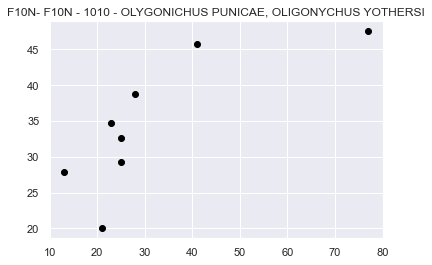

------------------------------------------------------------
F10N - F10N - 1007 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 33
Coeficiente: [3.28513714 1.91097189] 
------------------------------------------------------------------


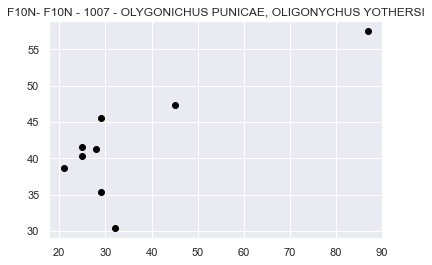

------------------------------------------------------------
F10N - F10N - 1030 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 33
Coeficiente: [ 6.60418518 -5.90326061  2.57251707] 
------------------------------------------------------------------


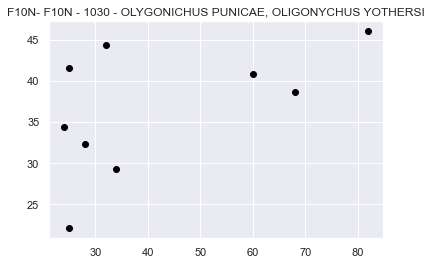

------------------------------------------------------------
F10N - F10N - 1017 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 30
Coeficiente: [ 6.84076471 -0.52405224] 
------------------------------------------------------------------


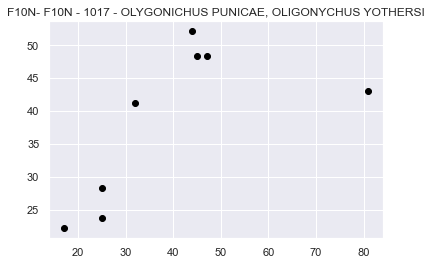

------------------------------------------------------------
F10N - F10N - 1029 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 33
Coeficiente: [0.19260612 3.52575631] 
------------------------------------------------------------------


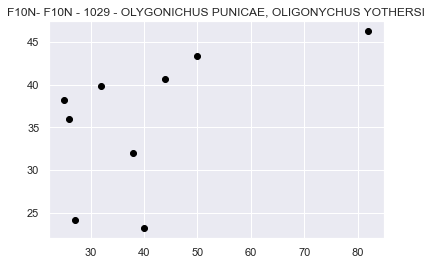

------------------------------------------------------------
F10N - F10N - 1014 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 33
Coeficiente: [3.95670775 1.50555009] 
------------------------------------------------------------------


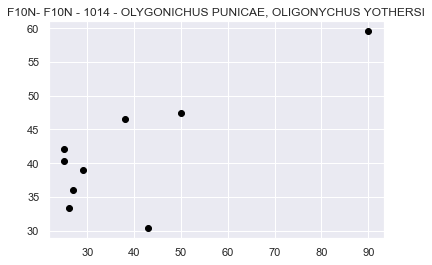

------------------------------------------------------------
F10N - F10N - 1011 - OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI Total: 33
Coeficiente: [4.17187228] 
------------------------------------------------------------------


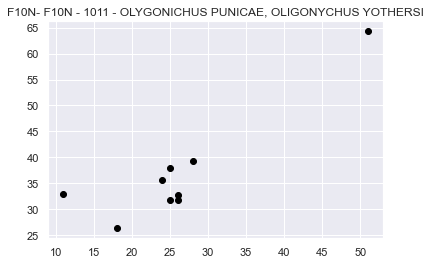

In [26]:
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Porcentaje'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    df_union = df_union[['Fecha','ET','TMP_PROM','T_MIN','T_MAX','RS_PROM','HM_PROM','Porcentaje']]        
                                   
                    df_union[["Porcentaje"]] = df_union[["Porcentaje"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Porcentaje'] > 0.60]

                    if dfCorrelacion_index.shape[0] > 1:   
                        
                        arrColumns = dfCorrelacion_index.columns
                        arrColumnsUnion = []
                        ###########################################
                        for column in arrColumns:
                            if (dfCorrelacion_index[column]['Porcentaje'] > 0.60) & (column != 'Porcentaje'):
                                    arrColumnsUnion.append(column)
                        ############################################  
                         #Creando regresión lineal
                        df_union = df_union.drop('Fecha' ,axis=1)
                        df_union = df_union.fillna(df_union.mean())
                        if df_union[arrColumnsUnion].shape[0] > 1:   
                            df_union.to_excel('datasets/{}_{}_{}_{}.xlsx'.format(filtrado,turno,lote,plaga))
                            x = df_union[arrColumnsUnion]
                            y = df_union['Porcentaje']
                            plt.title('F{}- {} - {} - {}'.format(filtrado,turno, lote, plaga))
                            print('------------------------------------------------------------')
                            X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state=0)
                            lrm = LinearRegression()
                            #lrm = LogisticRegression()
                            lrm.fit(X_train,y_train)
                            predicciones = lrm.predict(X_test)
                            print('F{} - {} - {} - {} Total: {}'.format(filtrado,turno, lote, plaga, x.shape[0]))
               
                            plt.scatter(y_test, predicciones,  color='black')

                            print('Coeficiente: {} '.format(lrm.coef_))
                            print('------------------------------------------------------------------')
                            plt.show()
                            
                            # Export the classifier to a file
                            joblib.dump(predicciones, 'model.joblib')
    break